## About this notebook:
In this Notebook 2 vactorizers are examined for sentiment analysis: Count and TF-IDF on corpus. Once with and Once without processing text.<br>
For each approach, 4 models are built to classify text : Logistic Regression, Random Forest, XGBoost and Naive Bayes. <br>
Best Result is Logistic Regression, with TF-IDF and no text processing.

In [22]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import string
import time
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE , SMOTEN

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from xgboost import XGBClassifier

from joblib import dump , load

## Importing and Splitting Data

In [8]:
# Preparing the main corpus
main_df= pd.read_csv('data/reviews.csv')

# Remove nan reviews
df= main_df.copy()
df.dropna(subset= ['Review Text'], inplace= True)

print('main df and clean df shape:',main_df.shape , df.shape)

# X , y

X = df['Review Text']
y= df["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)

main df and clean df shape: (23486, 11) (22641, 11)
X.shape: (22641,) 	 y_shape: (22641, 1)
train_test_split: (15848,) (6793,) 	 (15848, 1) (6793, 1)


In [20]:
df.rename(columns = {'Recommended IND': 'Recommended'}, inplace= True)
df['polarity'] = df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended,Positive Feedback Count,Division Name,Department Name,Class Name,polarity
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891


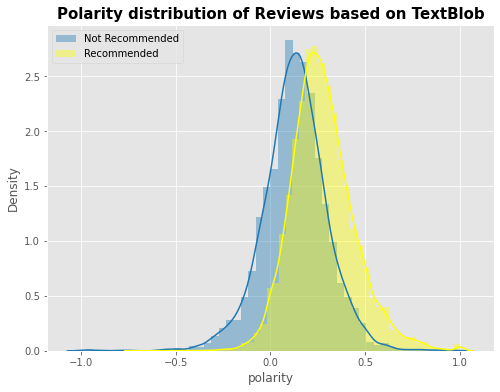

In [24]:
## TextBlob EDA

fig, ax = plt.subplots(figsize= (8,6))
sns.distplot(df.polarity[df.Recommended ==0], color ='tab:blue', label= 'Not Recommended').set_title("Polarity distribution of Reviews based on TextBlob",fontdict= { 'fontsize': 15, 'fontweight':'bold'} )
sns.distplot(df.polarity[df.Recommended ==1], color ='yellow', label = 'Recommended')
#sns.set(font_scale=1.2)
plt.legend(loc= 'upper left')
plt.savefig('images/polarity-rec0.png', dpi=300)

In [ ]:
## The plot above shows the two distributions of recommended and not recommended are very close to eachother.
# The threshold of 

In [1]:
def model_predictions(model_name, X_train,y_train,X_test, y_test):
    
    model = model_name
    model.fit(X_train, y_train)
    
    print(model_name)
    acc = cross_val_score(model, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(model, X_test, y_test, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:  \n", cm)
    print("Classification Report \n", classification_report( y_test, predictions))
    print('average percision score', average_precision_score(y_test, predictions, average= 'weighted'))

## Customized Stop-Words and text cleaning:

In [4]:
punct = set(string.punctuation)

ps = PorterStemmer()

remove_sw_list=['not', 'no']
sw = [i for i in stopwords.words('english') if i not in remove_sw_list]

def text_prep_stop_stem(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #return text
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    return " ".join([ps.stem(word) for word in punc_removed.split() if not word in sw])
    #return [word for word in punc_removed.split() if not word in sw]

## Count Vectorizer with no text pre-processing:

In [6]:
#CountVectorizer Without pre-preocessing
cv = CountVectorizer(binary = True, stop_words= None, ngram_range=(1,1))
cv.fit_transform(X_train)
train_feature_set = cv.transform(X_train)
test_feature_set = cv.transform(X_test)

In [7]:
# Logistic 
lr = LogisticRegression(class_weight= 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)


LogisticRegression(class_weight='balanced')
Accuracy: 0.869
Confusion Matrix:  
 [[ 895  335]
 [ 545 5018]]
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.73      0.67      1230
           1       0.94      0.90      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.78      0.81      0.79      6793
weighted avg       0.88      0.87      0.87      6793

average percision score 0.9258102484740472


In [28]:
# RF
rf = RandomForestClassifier(class_weight= 'balanced')
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)


RandomForestClassifier(class_weight='balanced')
Accuracy: 0.842
Confusion Matrix:  
 [[ 132 1098]
 [  12 5551]]
Classification Report 
               precision    recall  f1-score   support

           0       0.92      0.11      0.19      1230
           1       0.83      1.00      0.91      5563

    accuracy                           0.84      6793
   macro avg       0.88      0.55      0.55      6793
weighted avg       0.85      0.84      0.78      6793

average percision score 0.8348280201241333


In [21]:
# Gaussian Naieve Bayes
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.503
Confusion Matrix:  
 [[ 624  606]
 [2114 3449]]
Classification Report 
               precision    recall  f1-score   support

           0       0.23      0.51      0.31      1230
           1       0.85      0.62      0.72      5563

    accuracy                           0.60      6793
   macro avg       0.54      0.56      0.52      6793
weighted avg       0.74      0.60      0.64      6793

average percision score 0.8385375546995765


In [8]:
## XG Boost
xgb = XGBClassifier()
model_predictions(xgb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

[17:55:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[18:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used 

#### Logistic Regression has the best results

## Count vectorizer with Pre-Processed text

In [9]:
# Cleaning text
clean_X = X.apply(lambda x: text_prep_stop_stem(x))
#join_clean_X = clean_X.apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(clean_X , y , stratify =y , test_size = 0.3)
# Sample
clean_X[7]

'order carbon store pick ton stuff alway tri use top pair skirt pant everyth went color realli nice charcoal shimmer went well pencil skirt flare pant etc compaint bit big sleev long not go petit also bit loos no xx kept wil ldecid later sinc light color alreadi sold hte smallest size'

In [22]:
# create countvectorizer:
start_time = time.time()

cv = CountVectorizer(binary = True, stop_words= sw, ngram_range=(1,2) ,min_df = 5, max_df = 0.95)
cv.fit_transform(X_train)
train_feature_set = cv.transform(X_train)
test_feature_set = cv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.05  mins


In [23]:
lr = LogisticRegression(class_weight= 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression(class_weight='balanced')
Accuracy: 0.887
Confusion Matrix:  
 [[ 875  355]
 [ 424 5139]]
Classification Report 
               precision    recall  f1-score   support

           0       0.67      0.71      0.69      1230
           1       0.94      0.92      0.93      5563

    accuracy                           0.89      6793
   macro avg       0.80      0.82      0.81      6793
weighted avg       0.89      0.89      0.89      6793

average percision score 0.9265082709917446


In [25]:
# RF
rf = RandomForestClassifier(class_weight= 'balanced')
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier(class_weight='balanced')
Accuracy: 0.871
Confusion Matrix:  
 [[ 383  847]
 [  62 5501]]
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.31      0.46      1230
           1       0.87      0.99      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.86      0.65      0.69      6793
weighted avg       0.87      0.87      0.84      6793

average percision score 0.8660411877970953


In [26]:
# NB
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.803
Confusion Matrix:  
 [[ 232  998]
 [ 213 5350]]
Classification Report 
               precision    recall  f1-score   support

           0       0.52      0.19      0.28      1230
           1       0.84      0.96      0.90      5563

    accuracy                           0.82      6793
   macro avg       0.68      0.58      0.59      6793
weighted avg       0.78      0.82      0.79      6793

average percision score 0.841871795420048


In [65]:
X = df['Review Text']
y= df["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)

X.shape: (22641,) 	 y_shape: (22641, 1)
train_test_split: (15848,) (6793,) 	 (15848, 1) (6793, 1)


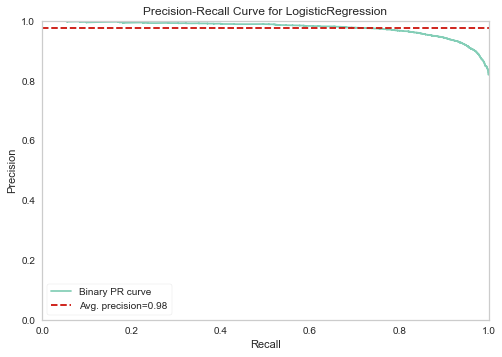

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [271]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    lr,
    per_class=True,
    
)
viz.fit(train_feature_set, y_train)
viz.score(test_feature_set, y_test)
viz.show()

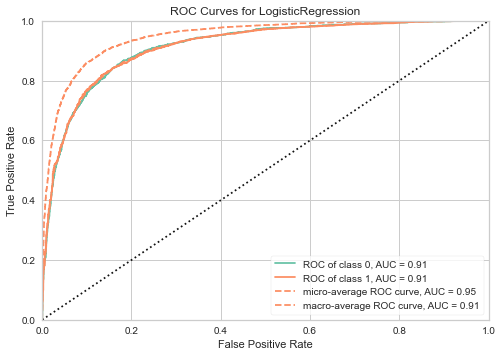

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [277]:
from yellowbrick.classifier import ROCAUC

model = lr
viz = ROCAUC(model)

viz.fit(train_feature_set, y_train)
viz.score(test_feature_set, y_test)
viz.show()

In [ ]:
## Checking best threshold for LR model

In [248]:
# logistic regresion
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.883
Confusion Matrix:  
 [[ 700  530]
 [ 250 5313]]
Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.57      0.64      1230
           1       0.91      0.96      0.93      5563

    accuracy                           0.89      6793
   macro avg       0.82      0.76      0.79      6793
weighted avg       0.88      0.89      0.88      6793



In [238]:
pred_proba_df = pd.DataFrame(lr.predict_proba(test_feature_set))
threshold_list = [0.3,0.4,0.45,0.5, 0.51, 0.6]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_f1 = round(f1_score(y_test, y_test_pred.loc[:,1].values),3)
    print('F1: {}'.format(test_f1))


******** For i = 0.3 ******
F1: 0.932

******** For i = 0.4 ******
F1: 0.933

******** For i = 0.45 ******
F1: 0.933

******** For i = 0.5 ******
F1: 0.934

******** For i = 0.51 ******
F1: 0.933

******** For i = 0.6 ******
F1: 0.933


## TF-IDF with No pre-processed text

In [29]:
X = df['Review Text']
y= df["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)

X.shape: (22641,) 	 y_shape: (22641, 1)
train_test_split: (15848,) (6793,) 	 (15848, 1) (6793, 1)


In [10]:
# create tfidf vectorizer:

tv = TfidfVectorizer(ngram_range=(1,1))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)


In [32]:
# logistic regression:
lr = LogisticRegression(class_weight = 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression(class_weight='balanced')
Accuracy: 0.871
Confusion Matrix:  
 [[1013  217]
 [ 653 4910]]
Classification Report 
               precision    recall  f1-score   support

           0       0.61      0.82      0.70      1230
           1       0.96      0.88      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.78      0.85      0.81      6793
weighted avg       0.89      0.87      0.88      6793

average percision score 0.9413889306872275


In [31]:
# Random Forest:
rf = RandomForestClassifier(class_weight = 'balanced')
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier(class_weight='balanced')
Accuracy: 0.839
Confusion Matrix:  
 [[ 131 1099]
 [  19 5544]]
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.11      0.19      1230
           1       0.83      1.00      0.91      5563

    accuracy                           0.84      6793
   macro avg       0.85      0.55      0.55      6793
weighted avg       0.84      0.84      0.78      6793

average percision score 0.8345093095750467


In [33]:
# Naive Bayes:
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.503
Confusion Matrix:  
 [[ 608  622]
 [2100 3463]]
Classification Report 
               precision    recall  f1-score   support

           0       0.22      0.49      0.31      1230
           1       0.85      0.62      0.72      5563

    accuracy                           0.60      6793
   macro avg       0.54      0.56      0.51      6793
weighted avg       0.73      0.60      0.64      6793

average percision score 0.8368621384736372


In [11]:
## XG Boost - TFIDF no processing
xgb = XGBClassifier()
model_predictions(xgb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

[19:41:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[19:48:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used 

## TF_IDF With pre-processed text

In [ ]:
# Cleaning text
clean_X = X.apply(lambda x: text_prep_stop_stem(x))
#join_clean_X = clean_X.apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(clean_X , y , stratify =y , test_size = 0.3)
# Sample
clean_X[7]

In [14]:
# create tfidf vectorizer:
start_time = time.time()

tv = TfidfVectorizer(stop_words= sw, ngram_range=(1,2))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.05  mins


In [37]:
train_feature_set.shape

(15848, 218293)

In [48]:
lr = LogisticRegression(class_weight = 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression(class_weight='balanced')
Accuracy: 0.884
Confusion Matrix:  
 [[ 936  294]
 [ 546 5017]]
Classification Report 
               precision    recall  f1-score   support

           0       0.63      0.76      0.69      1230
           1       0.94      0.90      0.92      5563

    accuracy                           0.88      6793
   macro avg       0.79      0.83      0.81      6793
weighted avg       0.89      0.88      0.88      6793

average percision score 0.9323047573531593


In [49]:
rf = RandomForestClassifier(class_weight = 'balanced')
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier(class_weight='balanced')
Accuracy: 0.847
Confusion Matrix:  
 [[  97 1133]
 [   4 5559]]
Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.08      0.15      1230
           1       0.83      1.00      0.91      5563

    accuracy                           0.83      6793
   macro avg       0.90      0.54      0.53      6793
weighted avg       0.85      0.83      0.77      6793

average percision score 0.8306849078241282


In [17]:
## XG Boost
xgb = XGBClassifier()
model_predictions(xgb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

[21:19:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[21:22:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used 

In [16]:
# create tfidf vectorizer for naive bayes:
start_time = time.time()

tv = TfidfVectorizer(stop_words= sw, ngram_range=(1,2), max_features= 5000)
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.08  mins


In [52]:
# Naive Bayes:
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.63
Confusion Matrix:  
 [[ 530  700]
 [1010 4553]]
Classification Report 
               precision    recall  f1-score   support

           0       0.34      0.43      0.38      1230
           1       0.87      0.82      0.84      5563

    accuracy                           0.75      6793
   macro avg       0.61      0.62      0.61      6793
weighted avg       0.77      0.75      0.76      6793

average percision score 0.8580623037473633


## Best Model Visualization
### Best model = logistic regression with TF-IDF and no text processing!

In [89]:
X = df['Review Text']
y= df["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)

X.shape: (22641,) 	 y_shape: (22641, 1)
train_test_split: (15848,) (6793,) 	 (15848, 1) (6793, 1)


LogisticRegression(class_weight='balanced')
Accuracy: 0.871
Confusion Matrix:  
 [[1013  217]
 [ 653 4910]]
Classification Report 
               precision    recall  f1-score   support

           0       0.61      0.82      0.70      1230
           1       0.96      0.88      0.92      5563

    accuracy                           0.87      6793
   macro avg       0.78      0.85      0.81      6793
weighted avg       0.89      0.87      0.88      6793

average percision score 0.9413889306872275


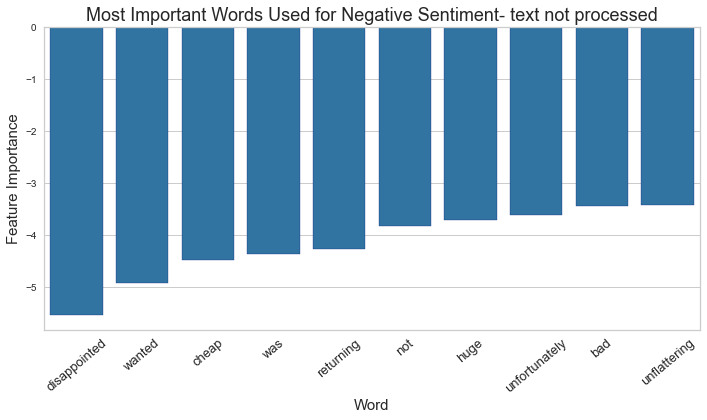

In [90]:
## TF-IDF No stopwords
tv = TfidfVectorizer(stop_words=None,ngram_range=(1,1))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

# LR
lr = LogisticRegression(class_weight = 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)


feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(tv.vocabulary_.keys())[list(tv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
#print(top_10_pos_w)
top_10_neg_w = [list(tv.vocabulary_.keys())[list(tv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
#print(top_10_neg_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]], color= 'tab:blue', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words Used for Negative Sentiment- text not processed",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/neg-not-processed')

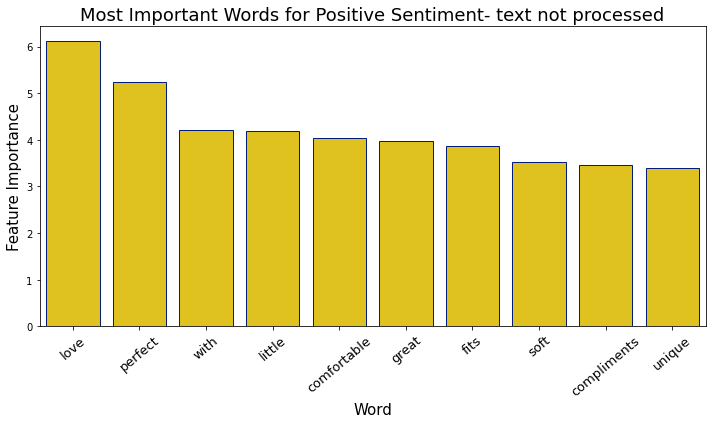

In [79]:
sns.set_palette("Set2", 9)
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]], color= 'gold', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words for Positive Sentiment- text not processed",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/pos-not-processed');

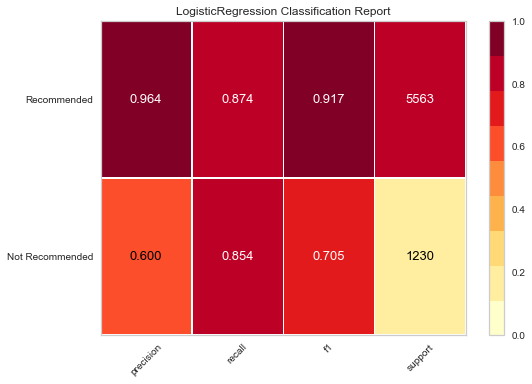

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [86]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(lr, classes=['Not Recommended', 'Recommended'], support=True, )

visualizer.fit(train_feature_set, y_train)  # Fit the visualizer and the model
visualizer.score(test_feature_set, y_test)# Evaluate the model on the test data
for label in visualizer.ax.texts:
    label.set_size(13)
plt.savefig('images/bestmodel.png', dpi=300)
visualizer.show()             # Draw/show the data

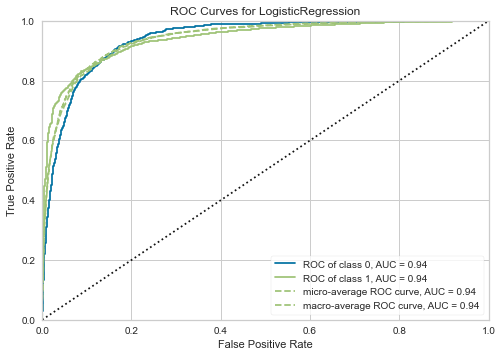

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [88]:
from yellowbrick.classifier import ROCAUC

model = lr
viz = ROCAUC(model)

viz.fit(train_feature_set, y_train)
viz.score(test_feature_set, y_test)
viz.show()

# Comaprison the important words with pre-processed text

In [81]:
## TF-IDF with stopwords

clean_X = X.apply(lambda x: text_prep_stop_stem(x))
#join_clean_X = clean_X.apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(clean_X , y , stratify =y , test_size = 0.3)

LogisticRegression(class_weight='balanced')
Accuracy: 0.884
Confusion Matrix:  
 [[ 941  289]
 [ 528 5035]]
Classification Report 
               precision    recall  f1-score   support

           0       0.64      0.77      0.70      1230
           1       0.95      0.91      0.92      5563

    accuracy                           0.88      6793
   macro avg       0.79      0.84      0.81      6793
weighted avg       0.89      0.88      0.88      6793

average percision score 0.9336838652397821


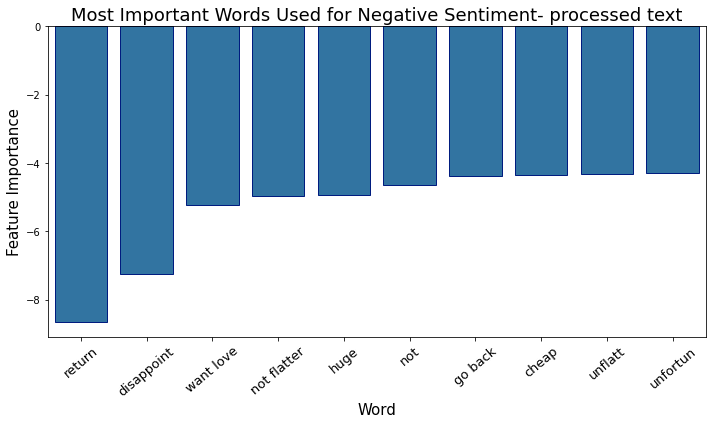

In [82]:
tv = TfidfVectorizer(stop_words= sw, ngram_range=(1,2))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

# LR
lr = LogisticRegression(class_weight = 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)


feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(tv.vocabulary_.keys())[list(tv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
#print(top_10_pos_w)
top_10_neg_w = [list(tv.vocabulary_.keys())[list(tv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
#print(top_10_neg_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]], color= 'tab:blue', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words Used for Negative Sentiment- processed text",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/neg-processed')

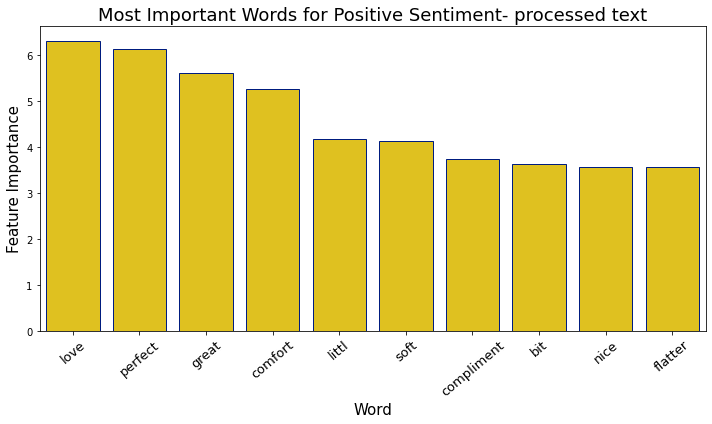

In [83]:
sns.set_palette("Set2", 9)
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]], color= 'gold', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words for Positive Sentiment- processed text",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/pos-processed');

## TEST

In [186]:
test_review = cv.transform(["I love the design and pattern of this top. \
it runs big so an xs was roomy on me but still cute. the neck is wide. \
i returned it bc the material of the top isn't for me. the texture is too soft." ])
lr.predict_proba(test_review)

array([[0.72092959, 0.27907041]])

In [11]:
from textblob import TextBlob
testimonial = TextBlob('This dress looked very cute on the website and that is why I ordered it. But I have to return it. it is very boxy.')
testimonial.sentiment

Sentiment(polarity=0.42500000000000004, subjectivity=0.65)

In [318]:
another_text =cv.transform(['This dress looked very cute on the website and that is why I ordered it. But I have to return it. It is very boxy.'])
lr.predict_proba(another_text)

array([[9.99568538e-01, 4.31462416e-04]])

## Building Pipeline for further steps

In [261]:
pipe_logistic = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("classifier", LogisticRegression()) #alpha=1 is the default
])
pipe_logistic.fit(X_train, y_train)
predictions = pipe_logistic.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1:', f1_score(y_test, predictions))

Accuracy: 0.8888561754747534
F1: 0.933144425750465


In [262]:
dump(pipe_logistic, 'sentiment.joblib')

['sentiment.joblib']

In [263]:
loaded_model = load('sentiment.joblib')
predictions = loaded_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1:', f1_score(y_test, predictions))

Accuracy: 0.8888561754747534
F1: 0.933144425750465
